<a href="https://colab.research.google.com/github/ali-workshop/Detect-diabetic-retinopathy-to-stop-blindness-before-it-s-too-late/blob/main/Detect_diabetic_retinopathy_to_stop_blindness_before_it's_too_late.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper for Comparison

## https://machineintelligenceresearchs.com/index.php/mir/article/view/88/88

## Code Objective: Detect diabetic retinopathy to stop blindness before it's too late

# Download the Dataset
### Overview
The APTOS 2019 Blindness Detection dataset is a medical image classification challenge hosted on Kaggle in 2019. The goal was to develop machine learning models to detect and classify different stages of diabetic retinopathy (DR) from fundus photography images of retinas .
### Key Points
Dataset Size: Over 5000 images of retinas were provided, each annotated by experts with one of five stages of Diabetic Retinopathy .
Classification Task: The task was to classify retina images into five categories representing different stages of DR:
*  No DR (Stage 0)
* Mild Nonproliferative DR (Stage 1)
* Moderate Nonproliferative DR (Stage 2)
* Severe Nonproliferative DR (Stage 3)
* Proliferative DR (Stage 4)




In [ ]:
!pip install opendatasets

In [ ]:
od.download('https://www.kaggle.com/competitions/aptos2019-blindness-detection/data')
# 6463b4d76523a3d511aadcdd9df378ec

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alolaa
Your Kaggle Key: ··········


100%|██████████| 9.51G/9.51G [07:55<00:00, 21.5MB/s]



Extracting archive ./aptos2019-blindness-detection/aptos2019-blindness-detection.zip to ./aptos2019-blindness-detection


# import libraries

In [ ]:
import os
import cv2
import random
import opendatasets as od
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set random seed for reproducibility
seed = 0
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

# Configure matplotlib and seaborn
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")


# Read Data Files

In [ ]:
train = pd.read_csv('/content/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('/content/aptos2019-blindness-detection/test.csv')

In [ ]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


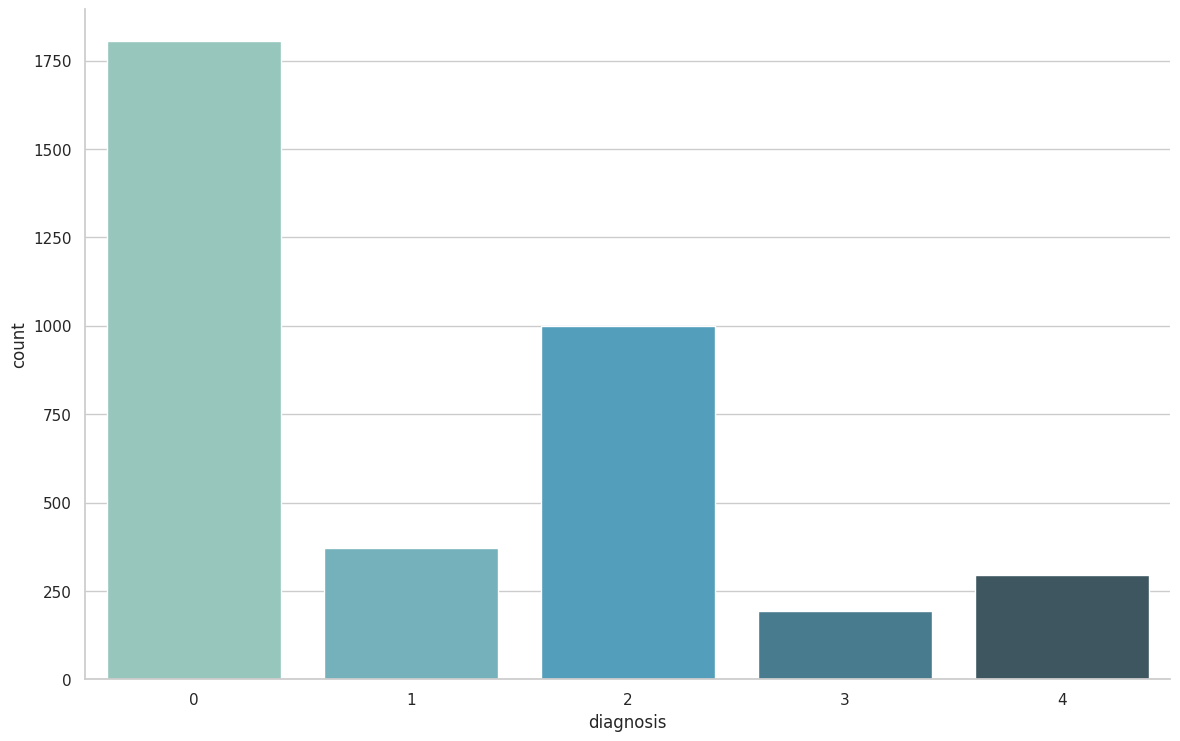

In [ ]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

#Plot some samples

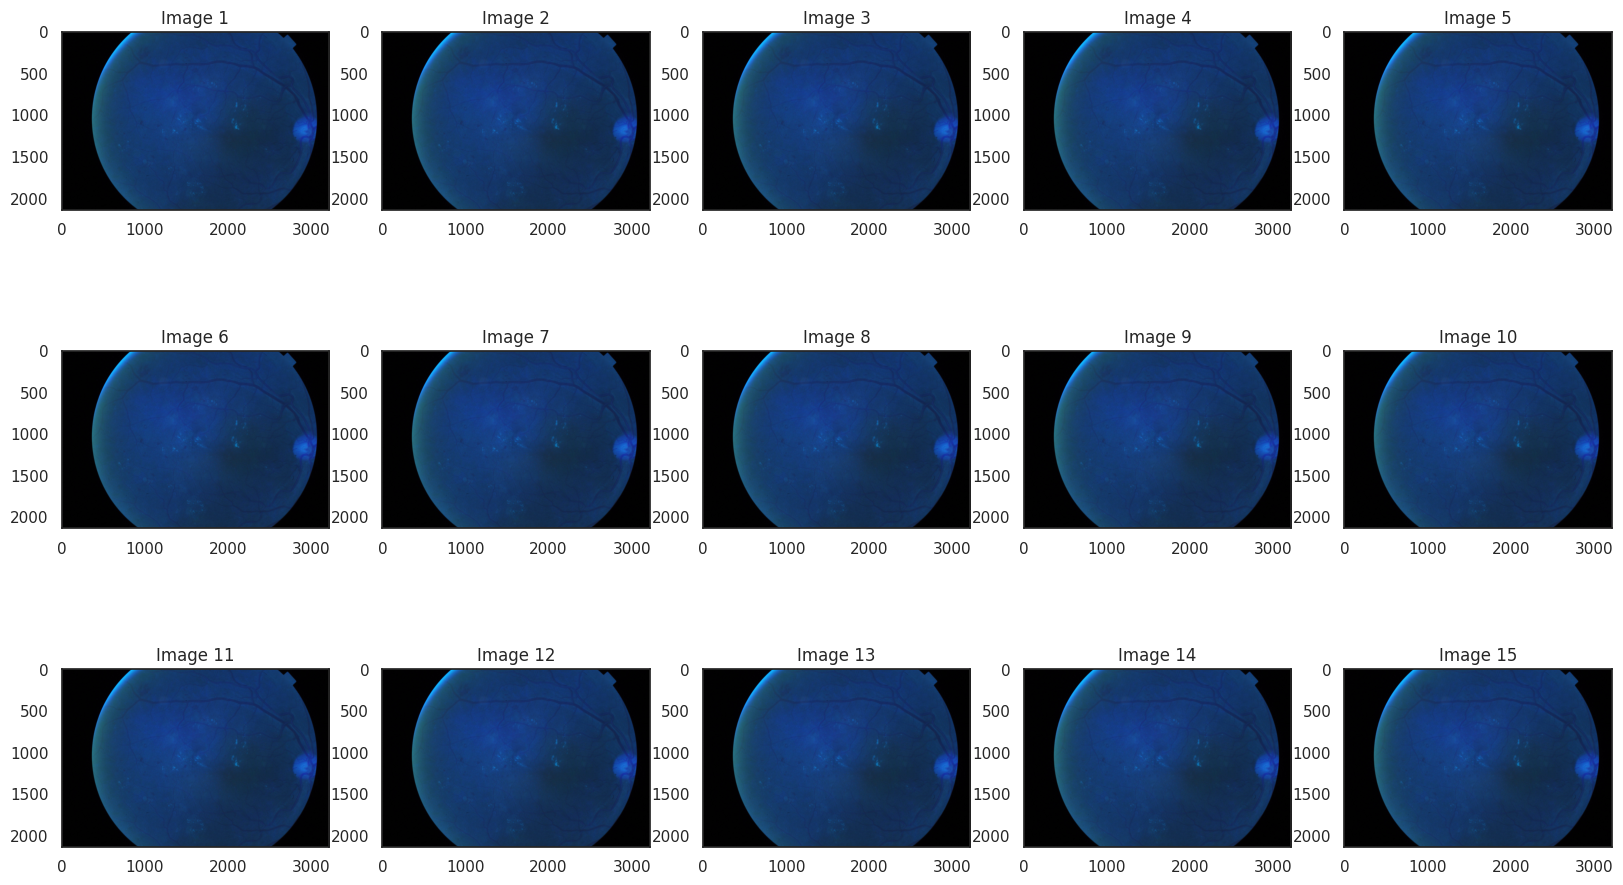

In [ ]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    img = cv2.imread('/content/aptos2019-blindness-detection/train_images/000c1434d8d7.png')
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1

plt.show()

In [ ]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


# Set up configuration

## Model parameters


In [ ]:
BATCH_SIZE = 8
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-2
HEIGHT = 512
WIDTH = 512
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()  # Assumes 'train' DataFrame is defined
ES_PATIENCE = 5  # Early stopping patience
RLROP_PATIENCE = 3  # Reduce LR on Plateau patience
DECAY_DROP = 0.5  # Learning rate decay factor


## Define the model creation function

In [ ]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)

    # Use pretrained weights directly, avoiding manual loading
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)

    return model


## Initialize the data generator with augmentation


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True
)

# Define training and validation generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training'
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='validation'
)

# Define the test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory="/content/aptos2019-blindness-detection/test_images",
    x_col="id_code",
    target_size=(HEIGHT, WIDTH),
    batch_size=1,
    shuffle=False,
    class_mode=None
)

# Create the model


In [ ]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

# Freeze all layers
for layer in model.layers:
    layer.trainable = False

# Unfreeze the last 5 layers for fine-tuning
for i in range(-5, 0):
    model.layers[i].trainable = True

# Compile the model
optimizer = optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()


Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 518, 518, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 256, 256, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 256, 256, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 256, 256, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 258, 258, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 128, 128, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 128, 128, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 128, 128, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 128, 128, 256)  │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 128, 128, 256)  │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 27,794,309 (106.03 MB)

 Trainable params: 4,206,597 (16.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# MODEL WARMUP

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=ES_PATIENCE,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=DECAY_DROP,
    patience=RLROP_PATIENCE,
    min_lr=LEARNING_RATE
)

# List of callbacks
callbacks = [early_stopping, reduce_lr]

# Calculate the steps for training and validation
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

# Training the model
history_warmup = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=WARMUP_EPOCHS,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/2
366/366 ━━━━━━━━━━━━━━━━━━━━ 478s 1s/step - accuracy: 0.3642 - loss: 3.2955 - val_accuracy: 0.4588 - val_loss: 1.4043 - learning_rate: 0.0010
Epoch 2/2
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3750 - loss: 1.4829 - val_accuracy: 0.7500 - val_loss: 1.1327 - learning_rate: 0.0010


#FINE TUNNING

## Model Compiletion

In [ ]:
# Unfreeze all layers for fine-tuning
for layer in model.layers:
    layer.trainable = True

# Define callbacks
es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=ES_PATIENCE,
    restore_best_weights=True,
    verbose=1
)

rlrop = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    patience=RLROP_PATIENCE,
    factor=DECAY_DROP,
    min_lr=1e-6,
    verbose=1
)

callback_list = [rlrop]

# Define optimizer and compile the model
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
metric_list = ["accuracy"]  # Ensure this is defined
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metric_list)


# plot the summry and start training and montoring

In [ ]:
# Display model summary
model.summary()

# Calculate steps per epoch for training and validation
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

# Fine-tune the model
history_finetuning = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=EPOCHS,
    callbacks=callback_list,
    verbose=1
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 518, 518, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 256, 256, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 256, 256, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 256, 256, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 258, 258, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 128, 128, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 128, 128, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 128, 128, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 128, 128, 256)  │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 128, 128, 256)  │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 27,794,309 (106.03 MB)

 Trainable params: 27,741,189 (105.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 589s 1s/step - accuracy: 0.6635 - loss: 0.3292 - val_accuracy: 0.4615 - val_loss: 0.6537 - learning_rate: 1.0000e-04
Epoch 2/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 0.0951 - val_accuracy: 0.2500 - val_loss: 0.9264 - learning_rate: 1.0000e-04
Epoch 3/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 500s 1s/step - accuracy: 0.7728 - loss: 0.2105 - val_accuracy: 0.4739 - val_loss: 0.4944 - learning_rate: 1.0000e-04
Epoch 4/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - accuracy: 0.6250 - loss: 0.3011 - val_accuracy: 0.7500 - val_loss: 0.1820 - learning_rate: 1.0000e-04
Epoch 5/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 491s 1s/step - accuracy: 0.8075 - loss: 0.1817 - val_accuracy: 0.7541 - val_loss: 0.2976 - learning_rate: 1.0000e-04
Epoch 6/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8750 - loss: 0.1425 - val_accuracy: 0.5000 - val_loss: 0.6955 - learning_rate: 1.0000e-04
Epoch 7/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accura

### as we see above the model stop wiht the Early Stopping callback reaching training accuracy: 0.9022 and val_accuracy: 0.8462

## Evaluation

Found 3662 validated image filenames.
3662/3662 ━━━━━━━━━━━━━━━━━━━━ 493s 133ms/step


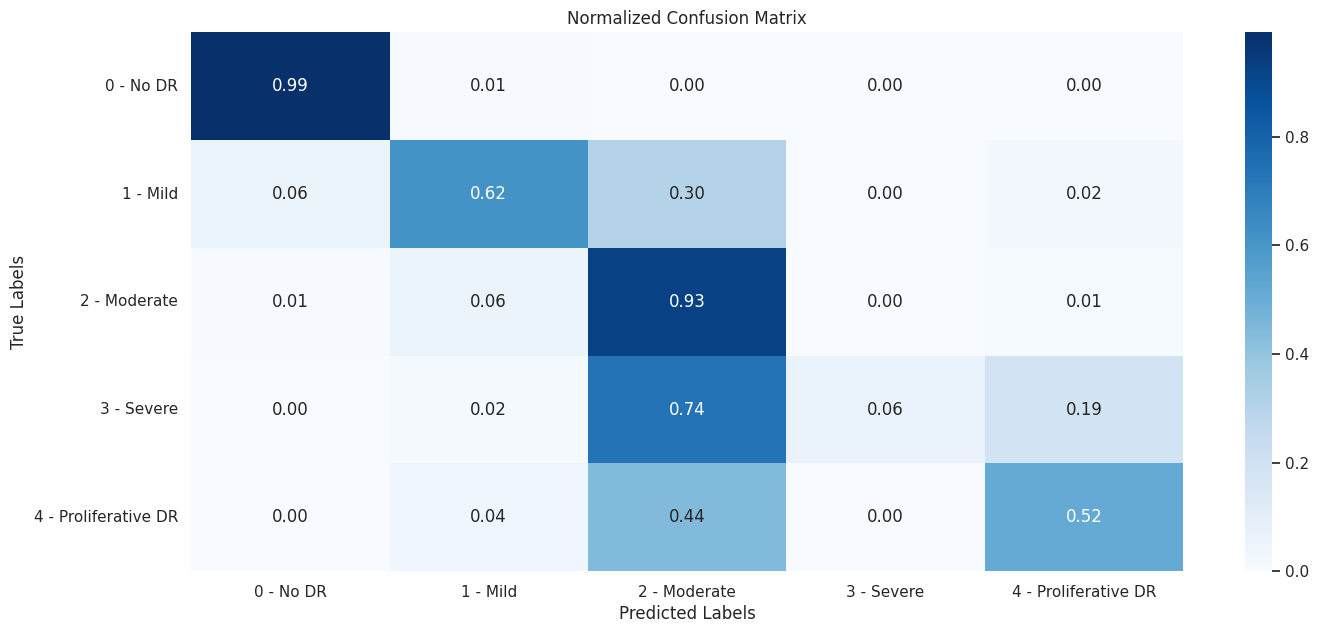

Train Cohen Kappa score: 0.896
1928/1928 ━━━━━━━━━━━━━━━━━━━━ 88s 46ms/step
        id_code  diagnosis
0  0005cfc8afb6          2
1  003f0afdcd15          2
2  006efc72b638          2
3  00836aaacf06          2
4  009245722fa4          4
5  009c019a7309          2
6  010d915e229a          2
7  0111b949947e          1
8  01499815e469          3
9  0167076e7089          0


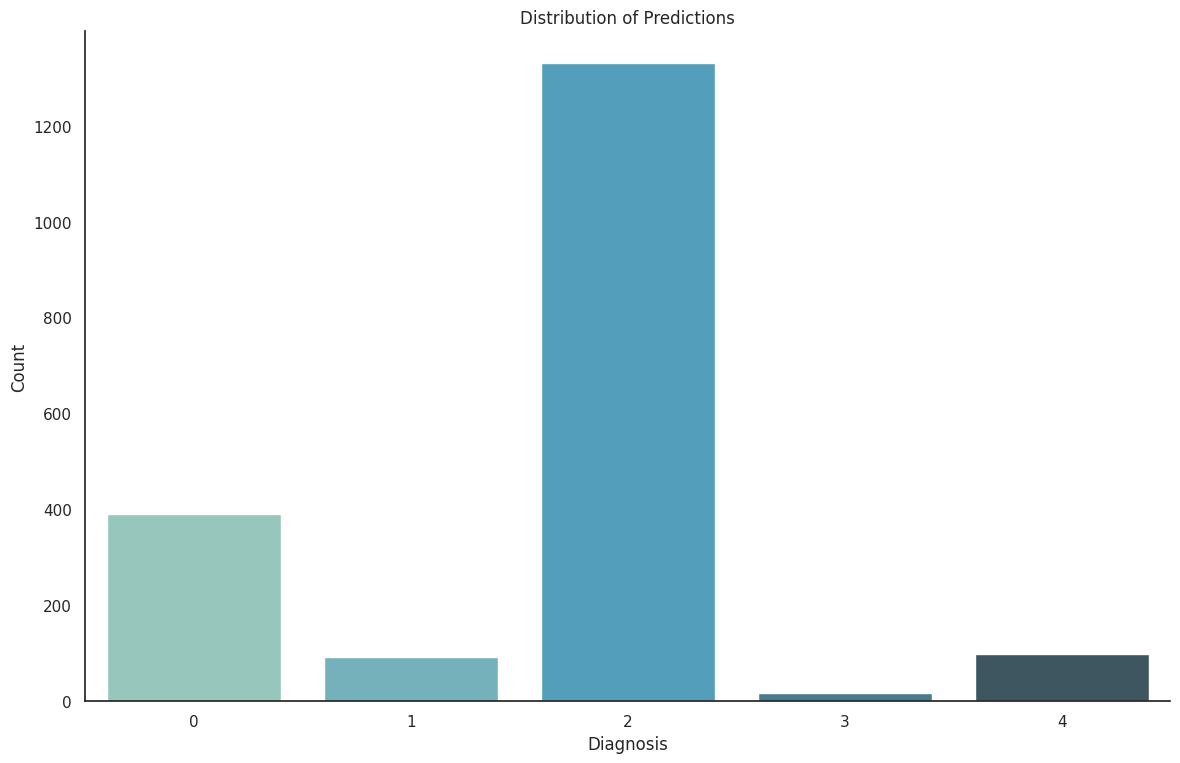

In [ ]:
# Import necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Create a data generator for prediction with image rescaling
complete_datagen = ImageDataGenerator(rescale=1./255)

# Configure the complete generator for the training set
complete_generator = complete_datagen.flow_from_dataframe(
    dataframe=train,                                  # Data source: training dataframe
    directory="/content/aptos2019-blindness-detection/test_images",  # Directory containing images
    x_col="id_code",                                  # Column in dataframe containing image filenames
    target_size=(HEIGHT, WIDTH),                      # Resize images to specified dimensions
    batch_size=1,                                     # Use batch size of 1 for single predictions
    shuffle=False,                                    # Keep the order consistent
    class_mode=None                                   # No class labels, as we are predicting
)

# Calculate steps for generator to cover the full dataset in one pass
STEP_SIZE_COMPLETE = complete_generator.n // complete_generator.batch_size

# Make predictions on the training set using the pre-trained model
train_preds = model.predict(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]  # Convert softmax predictions to class labels

# Define labels for the confusion matrix (specific to this classification problem)
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

# Generate and normalize the confusion matrix
cnf_matrix = confusion_matrix(train['diagnosis'].astype(int), train_preds)
cnf_matrix_norm = cnf_matrix.astype(float) / cnf_matrix.sum(axis=1)[:, np.newaxis]  # Normalize by row

# Create a DataFrame for the normalized confusion matrix to plot
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)

# Plot the normalized confusion matrix using seaborn heatmap
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Calculate and display Cohen's Kappa score to evaluate model performance
kappa_score = cohen_kappa_score(train_preds, train['diagnosis'].astype(int), weights='quadratic')
print("Train Cohen Kappa score: %.3f" % kappa_score)

# Reset the test generator to ensure it starts from the beginning
test_generator.reset()
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

# Predict on the test set
preds = model.predict(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]  # Convert softmax predictions to class labels

# Prepare a DataFrame for submission, mapping file names to predictions
filenames = test_generator.filenames
results = pd.DataFrame({'id_code': filenames, 'diagnosis': predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])  # Remove file extension for consistency

# Save the predictions to a CSV file for submission
results.to_csv('submission.csv', index=False)

# Display the first 10 rows of results to verify the format and content
print(results.head(10))

# Plot the distribution of predictions to understand class distribution in the test set
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.title("Distribution of Predictions")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

# THE END